In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import numpy as np
import pandas as pd

test = pd.read_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/test_tweets.csv",low_memory=False)

test.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,retweet_count,text,encoded_labels
0,567859569621372928,positive,1.000,NaN,NaN,0,@SouthwestAir though I work for another major ...,1
1,569618972535959552,negative,1.000,Customer Service Issue,1.0000,0,@AmericanAir I need to order a special meal an...,2
2,569723864252424193,negative,1.000,Can't Tell,0.7219,0,@AmericanAir Toby hates you lol,2
3,568176862159110144,negative,1.000,Cancelled Flight,1.0000,0,@united I was patient when they refused to swi...,2
4,569209051260678144,neutral,0.676,NaN,0.0000,0,@SouthwestAir I never got my flight confirmati...,0


In [4]:
!pip install -q nltk
!pip install -q torchmetrics
!pip install -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [5]:
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer


"""
    text pre processing pipeline. keeping it minimal since we want to leverage models
    vocabulary. We will vectorize the input text using BERT and then train a classifier
    on top of it. Before vectorizing, removing stopwords, punctuations are necessary to
    span the latent space properly.
"""

class PreProcess:
    def __init__(self,
                 model_id:str="prajjwal1/bert-small"):
        self.model_id = model_id
        self.model = SentenceTransformer(self.model_id)
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = word_tokenize


    def clean_text(self,text:str)->str:
        """
            Remove special characters, phone numbers,punctuation marks, links, and emails.
            Tokenize & Lemmatize the text
        """
        text = re.sub(r'https?://\S+|www\.\S+|<.*?>|[^A-Za-z0-9]+', ' ', text)
        text = re.sub(r'\b\d{10}\b|\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', ' ', text)
        tokens = self.tokenizer(text)
        lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Join the lemmatized tokens into a string
        cleaned_text = ' '.join(lemmatized_tokens)

        return cleaned_text

    def vectorize(self,text:str)->torch.Tensor:
        """
            Vectorizer function using the sentence transformer
            model.
        """
        return self.model.encode(text)

    def transform(self,text:str)->torch.Tensor:
        """
            The transform method, cleans the input
            text and then vectorizes it using a sentence
            transformer model.
        """
        return self.vectorize(
            self.clean_text(text)
        )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [6]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as dataloader

class TweetsDataset(Dataset):
    def __init__(self, annotations_file):
        self.transformer = PreProcess()
        self.data = annotations_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.loc[idx, 'encoded_labels']
        text_vector = self.transformer.transform(self.data.loc[idx,'text'])
        return text_vector, label


test_dataloader = dataloader(
    TweetsDataset(test.reset_index(drop=True)),batch_size=8
)

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import CalibrationError

class SentimentClassifier(torch.nn.Module):

    def __init__(self,input_embedd_dim:int,
                 num_labels:int):
        """
            A ANN impletention with dynamic
            probablity callibration during
            training
        """
        super(SentimentClassifier, self).__init__()
        self.linear1 = torch.nn.Linear(input_embedd_dim, 64)
        self.dropout = torch.nn.Dropout(p=0.1,inplace=False)
        self.norm1 = torch.nn.BatchNorm1d(64)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(64, 16)
        self.norm2 = torch.nn.BatchNorm1d(16)
        self.dense = torch.nn.Linear(16,num_labels)


    def forward(self, x):
        """
            The forward pass
        """
        x = self.activation(self.norm1(self.dropout(self.linear1(x))))
        x = self.norm2(self.linear2(x))
        x  = self.dense(x)
        return x


loss = nn.CrossEntropyLoss()

model = SentimentClassifier(input_embedd_dim=512,
                            num_labels=3)
optimizer = optim.Adam(model.parameters())
error = CalibrationError(num_classes=3
                         ,task='multiclass',norm='l1',n_bins=30)

In [10]:
PATH = '/content/drive/MyDrive/Projects/Temperature Scaling of NN/Checkpoint_TweetSentimentClassifier_wothout_scaling.pt'
checkpoint = torch.load(PATH)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

SentimentClassifier(
  (linear1): Linear(in_features=512, out_features=64, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense): Linear(in_features=16, out_features=3, bias=True)
)

In [12]:
from tqdm import tqdm
from torch.nn import Softmax as softmax

model.eval()
def eval_step(scale_value:float):
    test_loss, callibration_error = 0, 0
    # detach the parameter gradients
    with torch.no_grad():
        for eval_idx, eval_batch in enumerate(test_dataloader):
            eval_input = eval_batch[0].to(device)
            eval_labels = eval_batch[1].to(device)
            eval_output = model(eval_input)
            eval_output = eval_output/temp
            # Get the loss value for the current batch
            loss_val = loss(eval_output,eval_labels)
            test_loss += loss_val.data
            #Get the callibration error for the current batch
            # print(eval_output.softmax(dim=1).shape)
            batch_callibration_error = error(eval_output.softmax(dim=1).detach().cpu(),eval_labels)
            callibration_error +=  batch_callibration_error
            # break
        return test_loss, callibration_error

In [13]:
training_metrics = pd.read_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/TweetSentimentClassificationMetrics.csv')
training_metrics

,Epoch,Loss_train,ECE_train,Loss_eval,ECE_eval
0,0,tensor(465.3670),tensor(195.9897),tensor(205.3737),tensor(98.9527)
1,1,tensor(388.4088),tensor(173.8390),tensor(199.1546),tensor(95.3963)
2,2,tensor(363.6980),tensor(164.9780),tensor(199.6828),tensor(93.3934)
3,3,tensor(345.3289),tensor(158.4623),tensor(202.1320),tensor(92.2837)
4,4,tensor(323.8158),tensor(151.5547),tensor(206.5444),tensor(90.8784)
5,5,tensor(304.5513),tensor(143.2559),tensor(219.0013),tensor(89.1166)
6,6,tensor(289.2022),tensor(137.6121),tensor(216.0067),tensor(90.6445)
7,7,tensor(267.9523),tensor(130.2870),tensor(223.9833),tensor(88.2529)
8,8,tensor(250.2578),tensor(123.4113),tensor(231.4285),tensor(86.8805)
9,9,tensor(236.6586),tensor(117.6292),tensor(234.7858),tensor(87.8233)


In [15]:
"""
    we try to scale the logits with random temperature
    values ranging from 0 to 1 with a step size of .10 as a grid
    search method to see if the values provided during training
    are the most optimal ones or not.
"""

response = []
temp_values = np.arange(0,1,.1)

for temp in tqdm(temp_values):
    loss_val, error_val = eval_step(temp)
    response.append({
        'Temp Value':temp,
        'Loss':loss_val,
        'ECE':error_val
    })
    # break

100%|██████████| 10/10 [12:32<00:00, 75.21s/it]


In [16]:
response = pd.DataFrame(response)
response

,Temp Value,Loss,ECE
0,0.0,tensor(nan),tensor(81.6250)
1,0.1,tensor(2167.2915),tensor(87.6876)
2,0.2,tensor(1091.5576),tensor(86.9488)
3,0.3,tensor(736.3629),tensor(86.0771)
4,0.4,tensor(561.3947),tensor(85.3248)
5,0.5,tensor(458.5692),tensor(85.2832)
6,0.6,tensor(391.8351),tensor(85.5072)
7,0.7,tensor(345.7278),tensor(85.3526)
8,0.8,tensor(312.5052),tensor(85.6865)
9,0.9,tensor(287.8629),tensor(85.9789)


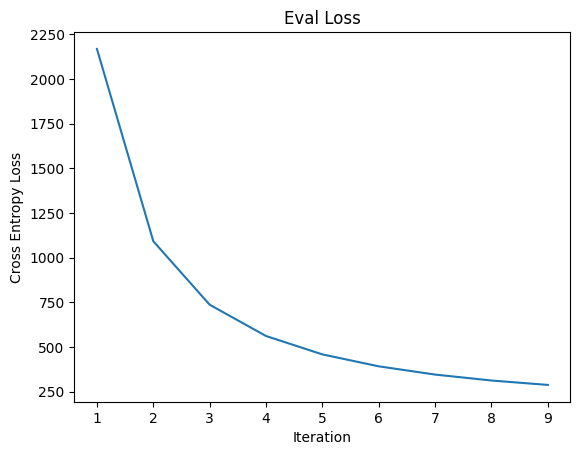

In [17]:
import matplotlib.pyplot as plt

plt.plot(response['Loss'].tolist())
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy Loss')
plt.title('Eval Loss')
plt.show()

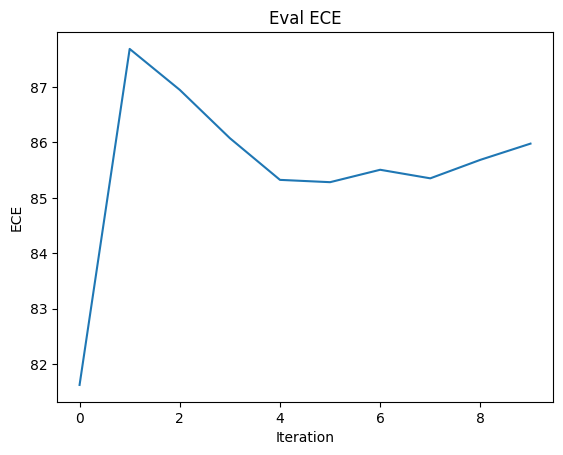

In [18]:
plt.plot(response['ECE'].tolist())
plt.xlabel('Iteration')
plt.ylabel('ECE')
plt.title('Eval ECE')
plt.show()